# 📊 Análise de Dados: PlayStation Store Brasil (PS5)

**Projeto:** Web Scraping & Data Analysis  
**Autor:** Gustavo Moreno Souza  
**Data:** Dezembro/2025

---

### 🎯 Objetivo do Projeto
Este notebook tem como objetivo analisar o ecossistema de preços da PSN Store (Ofertas e Catálogo). O projeto simula um pipeline de **Inteligência de Mercado**, respondendo a perguntas estratégicas:

1.  **Distribuição de Mercado:** Como os preços estão distribuídos? A maioria dos jogos é acessível ou premium?
2.  **Pricing:** Quais são os jogos mais caros (Top Tier) atualmente?
3.  **Oportunidade (Desconto %):** Quais títulos apresentam a redução de preço mais agressiva percentualmente?
4.  **Economia Real (R$):** Em quais jogos o jogador economiza mais dinheiro absoluto (custo-benefício)?
5.  **Segmentação:** Qual a proporção de jogos por faixa de preço (Econômico vs. Premium)?

---

### 🧠 A Motivação (Business Case)
Com a flutuação constante de preços na loja digital, jogadores e analistas enfrentam dificuldade para identificar **oportunidades reais**. 

Este projeto resolve isso automatizando:
*   A **coleta** de dados em tempo real (Scraping).
*   O **tratamento** e cálculo de métricas financeiras (ETL).
*   A **visualização** para tomada de decisão de compra (Analytics).

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração estética dos gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


### 📂 1. Carregamento e Visão Geral dos Dados
Vamos carregar o dataset processado (limpo) e verificar as primeiras linhas e tipos de dados.

In [2]:
# Carregando o CSV processado
df = pd.read_csv('../data/processed/psn_games_clean.csv')

# Exibindo as primeiras 5 linhas
display(df.head())

# Informações sobre colunas e tipos
print("\n--- Informações do Dataset ---")
df.info()

,Titulo,Preco_Atual,Desconto_Txt,Link,Data_Coleta,Preco_Num,Desconto_Pct,Preco_Original_Est,Economia_Reais,Status_Promocao
0,Edição Ultimate do EA SPORTS FC™ 26 para PS4 e...,"R$249,75",-50%,https://store.playstation.com/pt-br/product/UP...,2025-12-07,249.75,50,499.500000,249.750000,Promocao
1,Red Dead Redemption 2: Edição Definitiva,"R$99,98",-80%,https://store.playstation.com/pt-br/product/UP...,2025-12-07,99.98,80,499.900000,399.920000,Promocao
2,Gran Turismo® 7,"R$146,95",-58%,https://store.playstation.com/pt-br/product/UP...,2025-12-07,146.95,58,349.880952,202.930952,Promocao
3,Grand Theft Auto V (PS4™ e PS5™),"R$98,96",-67%,https://store.playstation.com/pt-br/product/UP...,2025-12-07,98.96,67,299.878788,200.918788,Promocao
4,God of War,"R$57,45",-50%,https://store.playstation.com/pt-br/product/UP...,2025-12-07,57.45,50,114.900000,57.450000,Promocao



--- Informações do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3730 entries, 0 to 3729
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Titulo              3730 non-null   object 
 1   Preco_Atual         3730 non-null   object 
 2   Desconto_Txt        3730 non-null   object 
 3   Link                3730 non-null   object 
 4   Data_Coleta         3730 non-null   object 
 5   Preco_Num           3730 non-null   float64
 6   Desconto_Pct        3730 non-null   int64  
 7   Preco_Original_Est  3730 non-null   float64
 8   Economia_Reais      3730 non-null   float64
 9   Status_Promocao     3730 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 291.5+ KB


### 💰 2. Estatísticas Descritivas
Aqui analisamos a média, mediana, preço mínimo e máximo encontrado.

In [3]:
# Estatísticas básicas (Média, Desvio Padrão, Mín, Máx)
estatisticas = df['Preco_Num'].describe()

print(f"💰 Preço Médio: R$ {estatisticas['mean']:.2f}")
print(f"💸 Jogo mais barato (não gratuito): R$ {df[df['Preco_Num'] > 0]['Preco_Num'].min():.2f}")
print(f"💎 Jogo mais caro: R$ {estatisticas['max']:.2f}")

# Mostra a tabela completa
display(pd.DataFrame(estatisticas))

💰 Preço Médio: R$ 40.90
💸 Jogo mais barato (não gratuito): R$ 0.29
💎 Jogo mais caro: R$ 547.12


,Preco_Num
count,3730.000000
mean,40.902517
std,47.767664
min,0.290000
25%,11.600000
50%,26.250000
75%,50.970000
max,547.120000


### 📊 3. Distribuição de Preços (Histograma)
Como os preços estão espalhados? A maioria é barata ou cara?

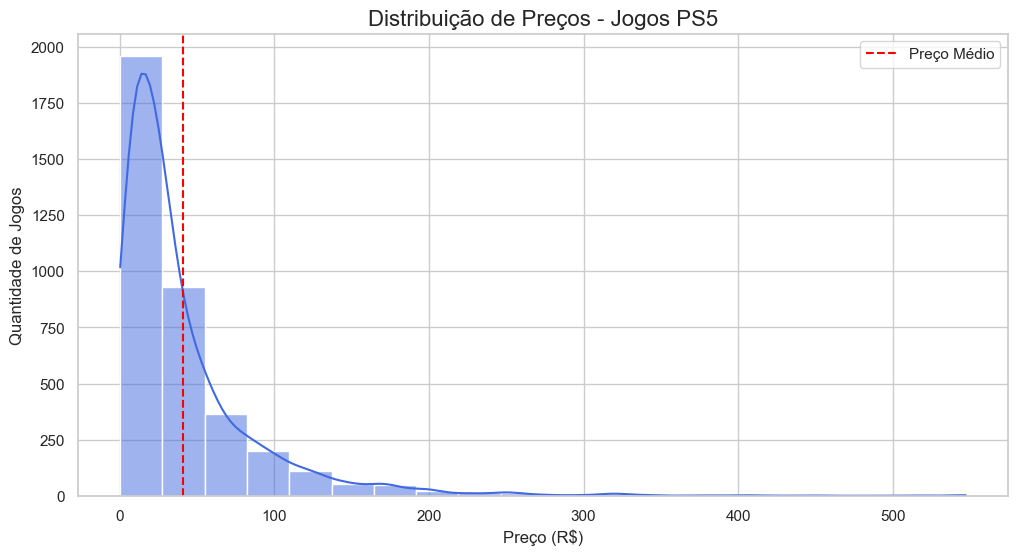

In [4]:
plt.figure(figsize=(12, 6))

# Histograma com curva de densidade (KDE)
sns.histplot(data=df, x='Preco_Num', bins=20, kde=True, color='royalblue')

# Linha da média
plt.axvline(df['Preco_Num'].mean(), color='red', linestyle='--', label='Preço Médio')

plt.title('Distribuição de Preços - Jogos PS5', fontsize=16)
plt.xlabel('Preço (R$)', fontsize=12)
plt.ylabel('Quantidade de Jogos', fontsize=12)
plt.legend()
plt.show()

### 🔥 4. Top 10 Jogos Mais Caros
Quais são os títulos que pesam mais no bolso? Geralmente são edições "Ultimate" ou "Deluxe".

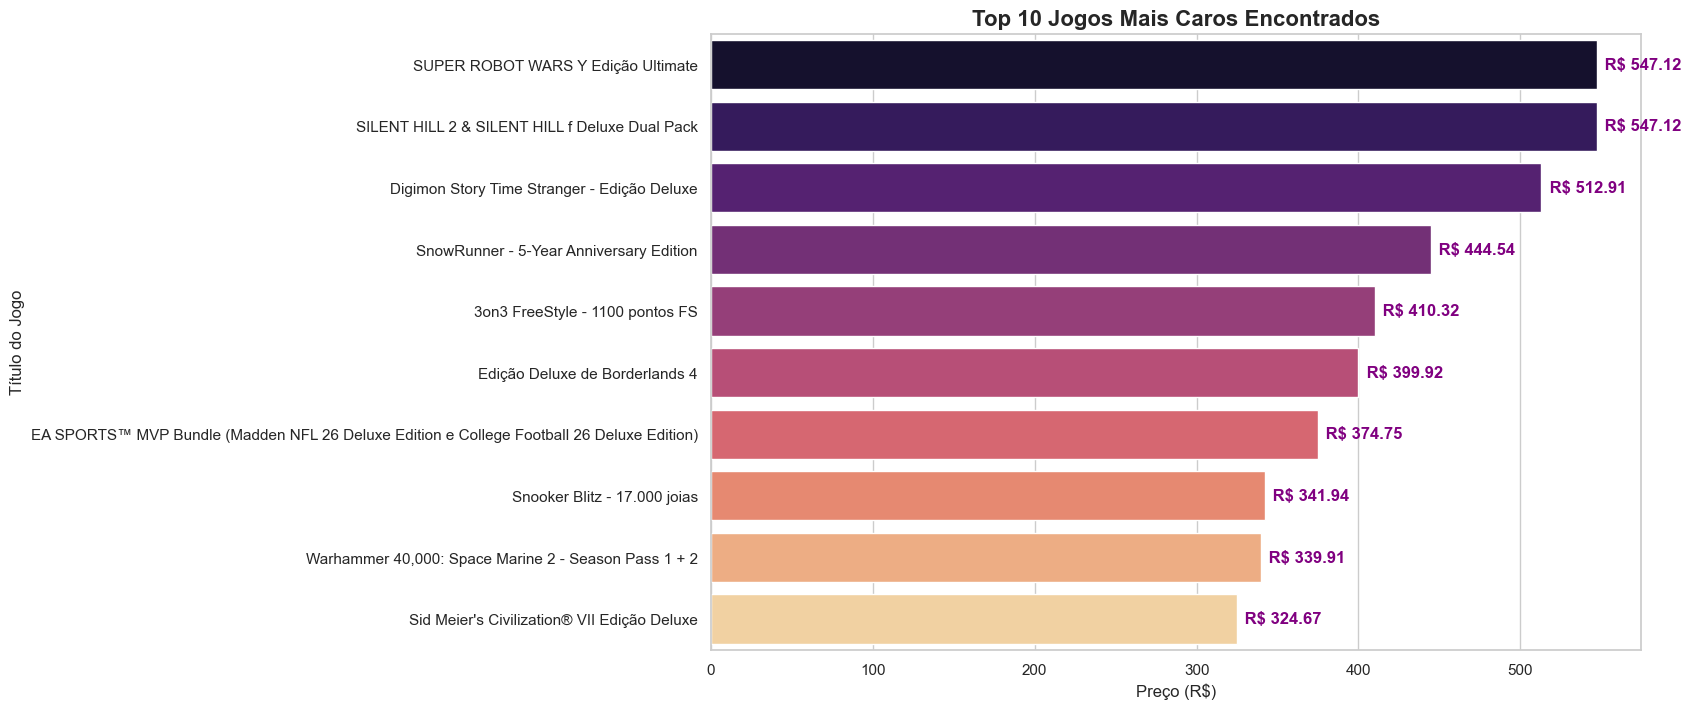

In [5]:
# Ordenação do dataset pelo valor numérico em ordem decrescente (highest to lowest)
df_sorted = df.sort_values(by='Preco_Num', ascending=False)

# Seleção dos 10 primeiros registros para compor o ranking
top_expensive = df_sorted.head(10)

# Configuração da área de plotagem
plt.figure(figsize=(12, 8))

# Renderização do gráfico de barras horizontal
sns.barplot(
    data=top_expensive, 
    y='Titulo', 
    x='Preco_Num', 
    hue='Titulo', 
    legend=False, 
    palette='magma'
)

# Customização de títulos e rótulos dos eixos
plt.title('Top 10 Jogos Mais Caros Encontrados', fontsize=16, fontweight='bold')
plt.xlabel('Preço (R$)', fontsize=12)
plt.ylabel('Título do Jogo', fontsize=12)

# Adição de anotações textuais (valores) ao final de cada barra
for index, value in enumerate(top_expensive['Preco_Num']):
    plt.text(value + 2, index, f' R$ {value:.2f}', va='center', fontweight='bold', color='purple')

plt.show()

### 🏷️ 5. Faixas de Preço
Vamos categorizar os jogos em faixas de preço para entender o perfil da loja.
- **Grátis:** R$ 0,00
- **Econômico:** Até R$ 150,00
- **Padrão:** R$ 150,00 a R$ 300,00
- **Premium:** Acima de R$ 300,00

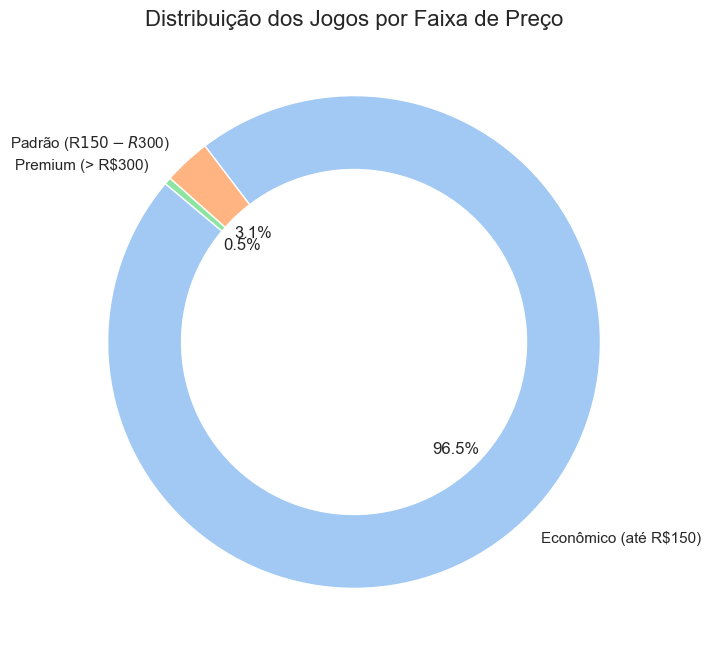

In [6]:
# Criando categorias
def categorizar(preco):
    if preco == 0: return 'Gratuito'
    elif preco <= 150: return 'Econômico (até R$150)'
    elif preco <= 300: return 'Padrão (R$150-R$300)'
    else: return 'Premium (> R$300)'

df['Categoria'] = df['Preco_Num'].apply(categorizar)

# Contagem
contagem = df['Categoria'].value_counts()

# Gráfico de Rosca (Donut Chart)
plt.figure(figsize=(8, 8))
plt.pie(contagem, labels=contagem.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribuição dos Jogos por Faixa de Preço', fontsize=16)

# Círculo branco no meio para virar "Rosca"
my_circle = plt.Circle((0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

### 🔥 6. Caçador de Ofertas: Ranking de Descontos (%)
Aqui identificamos as **oportunidades agressivas**.
Jogos com descontos acima de 70-80% geralmente indicam promoções de fim de temporada ou títulos mais antigos que a produtora quer alavancar na base de jogadores.

> **Insight:** Um desconto alto (%) não significa necessariamente que o jogo é barato, apenas que o preço caiu drasticamente em relação ao original.

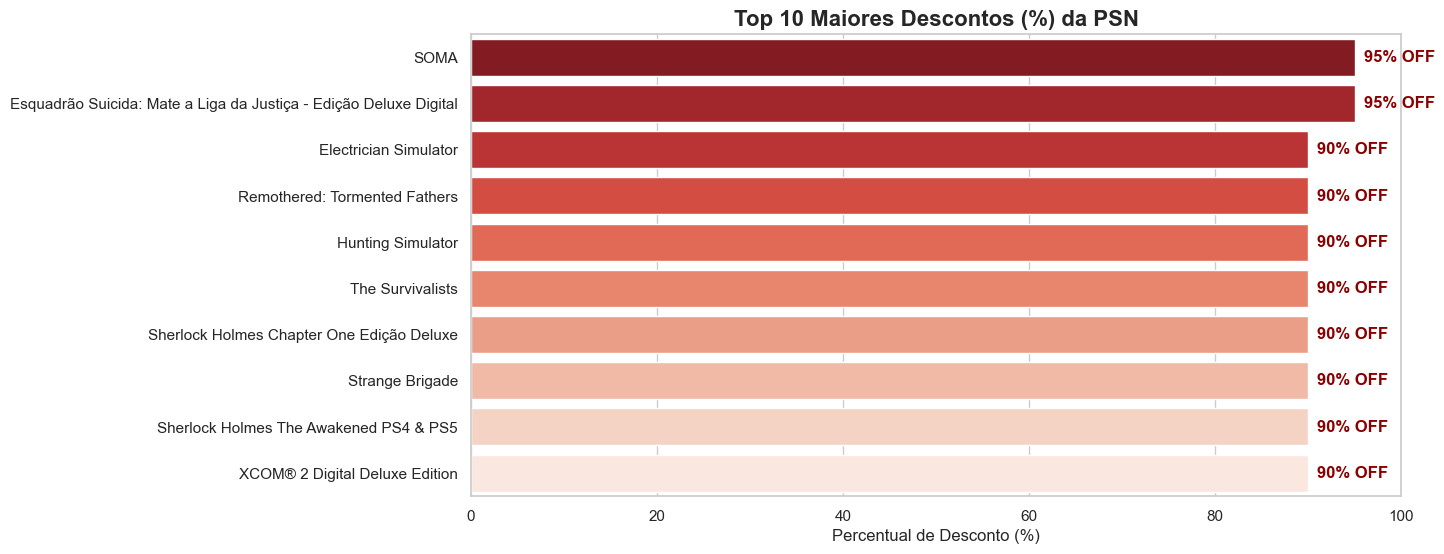

In [7]:
# Filtra só quem tem desconto
promocoes = df[df['Desconto_Pct'] > 0].copy()

if len(promocoes) > 0:
    # Top 10 maiores descontos
    top_descontos = promocoes.sort_values(by='Desconto_Pct', ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    
    sns.barplot(
        data=top_descontos, 
        y='Titulo', 
        x='Desconto_Pct', 
        hue='Titulo', 
        legend=False, 
        palette='Reds_r'
    )
    
    plt.title('Top 10 Maiores Descontos (%) da PSN', fontsize=16, fontweight='bold')
    plt.xlabel('Percentual de Desconto (%)', fontsize=12)
    plt.ylabel('')
    plt.xlim(0, 100) # De 0 a 100%
    
    # Adiciona o texto na frente da barra
    for index, value in enumerate(top_descontos['Desconto_Pct']):
        plt.text(value + 1, index, f'{value}% OFF', va='center', fontweight='bold', color='darkred')

    plt.show()
else:
    print("Nenhuma promoção encontrada nesta coleta.")

### 💰 7. Economia Real: Onde o seu dinheiro rende mais?
Diferente da análise percentual, aqui focamos no **Valor Absoluto (R$)**.
Muitas vezes, um jogo AAA (lançamento) com 30% de desconto gera uma economia financeira maior do que um jogo indie com 80% de desconto.

*   **Barra Verde:** Valor que você deixa de gastar (Economia).
*   **Texto:** Comparativo "De / Por".

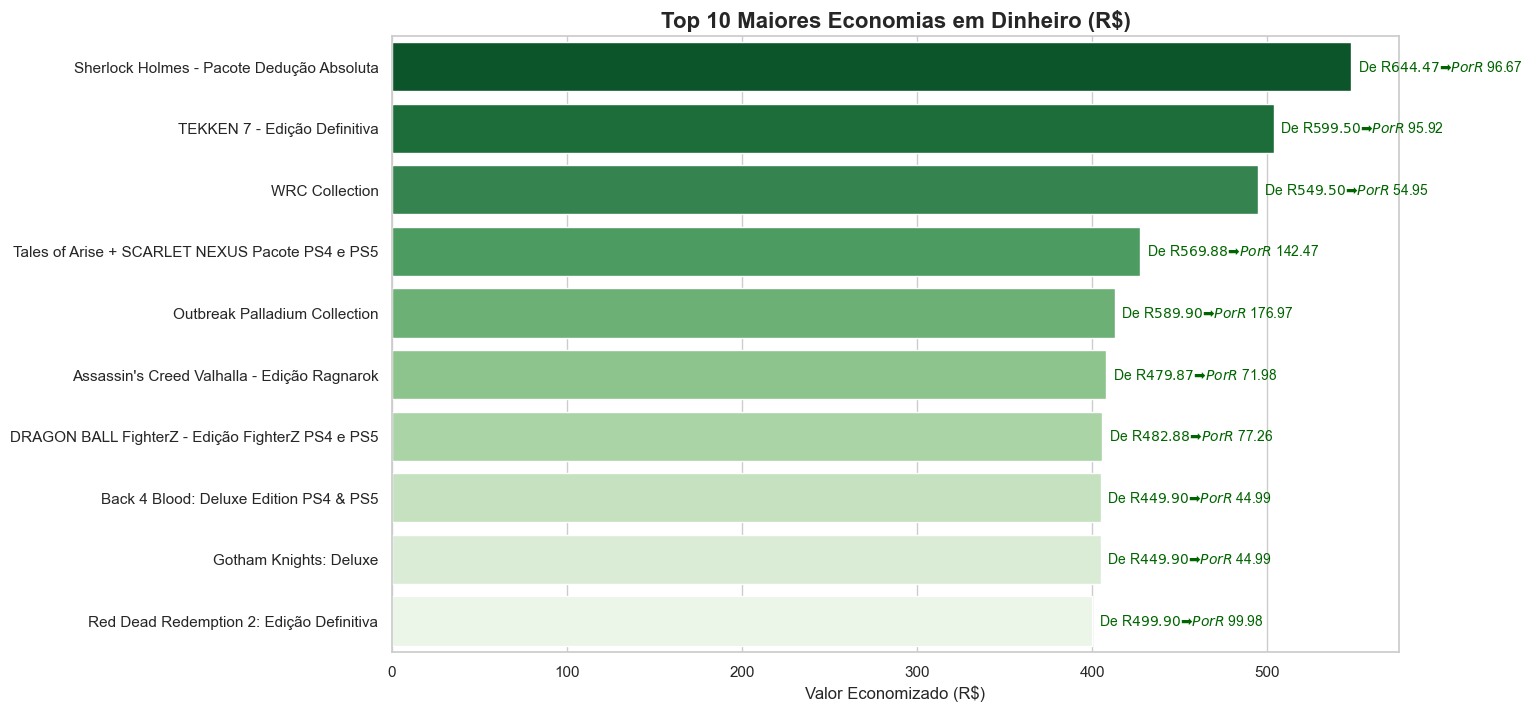

In [8]:
if len(promocoes) > 0:
    # Top 10 maiores economias em Reais
    top_economia = promocoes.sort_values(by='Economia_Reais', ascending=False).head(10)

    plt.figure(figsize=(13, 8)) 
    
    sns.barplot(
        data=top_economia, 
        y='Titulo', 
        x='Economia_Reais', 
        hue='Titulo', 
        legend=False, 
        palette='Greens_r'
    )

    plt.title('Top 10 Maiores Economias em Dinheiro (R$)', fontsize=16, fontweight='bold')
    plt.xlabel('Valor Economizado (R$)', fontsize=12)
    plt.ylabel('')
    
    for index, row in enumerate(top_economia.itertuples()):
        # Texto formatado: "De R$ 500.00 ➡ Por R$ 300.00"
        label = f' De R$ {row.Preco_Original_Est:.2f} ➡ Por R$ {row.Preco_Num:.2f}'
        
        plt.text(row.Economia_Reais + 2, index, label, va='center', fontsize=10, color='darkgreen')

    plt.show()
else:
    print("Sem dados de economia.")